<a href="https://colab.research.google.com/github/rridss/Pattern-Recognition/blob/main/image_captioning_using_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.kaggle.com/code/charanhu/image-captioning-using-lstm?scriptVersionId=105463110" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
image_ids = list(mapping.keys())
split=int(len(image_ids)*0.90)
train= image_ids[:split]
test=image_ids[split:]

In [ ]:
# <start> girl going into wooden building <end>
#            X                                           Y
# <start>                                                girl
# <start>  girl                                          going
# <start>  girl going                                    into
# .........................................
# <start> girl going into wooden building                <end>

In [ ]:
# craete data generator to get data in batch (avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y =list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n +=1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                #split the sequence into X, Y pairs
                for i in range(1, len(seq)):
                    #split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input seqence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

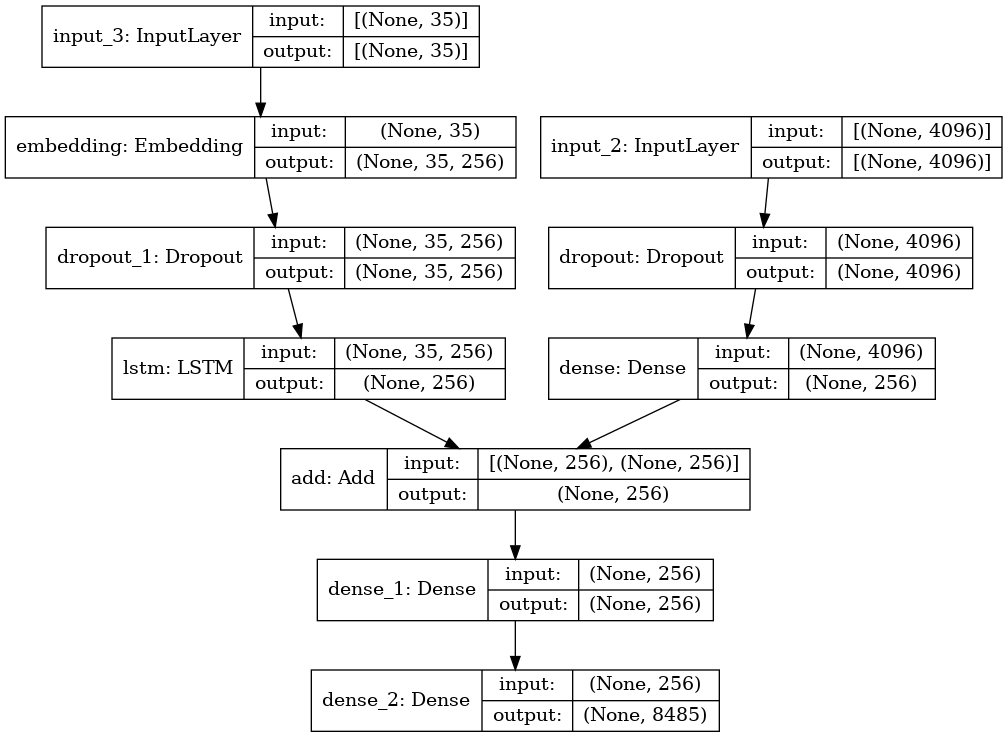

In [ ]:
# encoder model
# image feature layer
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layer
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


#decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 87s 384ms/step - loss: 2.1873


In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generaation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad sequences
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        #get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        #stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text+=" "+word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    #get actual caption
    captions= mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    #split ino words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    #append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculate BLEU score
print("BLEU-1:%f"% corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print("BLEU-2:%f"% corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1:0.540149
BLEU-2:0.315509


## Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    #image_name = ""
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('-------------Actual------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------Predicted---------------')
    print(y_pred)
    plt.imshow(image)

-------------Actual------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------Predicted---------------
startseq two dogs are fighting over red object in the snow endseq


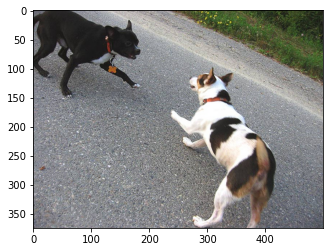

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

-------------Actual------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------Predicted---------------
startseq two women in pink clothes sit on the stairs endseq


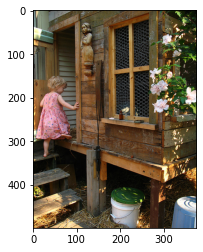

In [ ]:
generate_caption("1000268201_693b08cb0e.jpg")

-------------Actual------------
startseq child and woman are at waters edge in big city endseq
startseq large lake with lone duck swimming in it with several people around the edge of it endseq
startseq little boy at lake watching duck endseq
startseq young boy waves his hand at the duck in the water surrounded by green park endseq
startseq "two people are at the edge of lake facing the water and the city skyline ." endseq
--------------Predicted---------------
startseq two people are sitting on the edge of water endseq


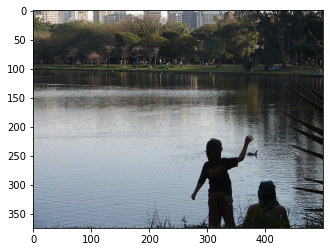

In [ ]:
generate_caption("1022454332_6af2c1449a.jpg")

### Observations:
1. Model working decently
2. Trying get insights of the image not 100%
3. If we increse the epoch we get more precise captions